### Project Topic: Suvived passengers from Titanic 
The primary objective of this analysis is to predict the survival of Titanic passengers based on various attributes. The dataset, sourced from Kaggle, comprises a range of passenger attributes, including age, gender, name, fare, and port of embarkation, in addition to a survival indicator (1 for survived, 0 for did not survive). Given the availability of training data with labeled outcomes, this is a supervised learning problem.

The focus of the analysis is predominantly on prediction rather than explanation. Consequently, while the importance and contribution of individual attributes to survival likelihood are acknowledged, they are not extensively explored. The primary metric for success in this analysis is the accuracy of survival predictions, reflecting the project's emphasis on predictive power over interpretive insights.

In [1]:
#used packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Used Data

The dataset for this analysis, provided by Kaggle, consists of two parts: a training set and a test set. However, since the test set does not include outcomes for survival, the analysis primarily utilizes the training set. This training set will be further split into separate training and testing subsets to facilitate model validation and performance assessment.

The dataset is relatively compact, with a total size of approximately 93KB and comprising 890 rows. All data is consolidated into a single CSV file. There is no need for joining multiple tables or datasets.

Below is a detailed overview of the columns present in the dataset, along with their respective descriptions:



| Variable | Definition                                 |
|----------|--------------------------------------------|
| survival | Survival                                   |
| pclass   | Ticket class                               |
| sex      | Sex                                        |
| Age      | Age in years                               |
| sibsp    | # of siblings / spouses aboard the Titanic |
| parch    | # of parents / children aboard the Titanic |
| ticket   | Ticket number                              |
| fare     | Passenger fare                             |
| cabin    | Cabin number                               |
| embarked | Port of Embarkation                        |

The data is avilable with this link;
https://www.kaggle.com/competitions/titanic/data

In [2]:
# data import and the preview
train = pd.read_csv('data/train.csv')
train_original = pd.read_csv('data/train.csv')
train.info()

test = pd.read_csv('data/test.csv')
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Data Cleaning

The preprocessing of the Titanic dataset involved several key steps to prepare the data for analysis. The data set are relatively clean, yet need some cleaning. Although several steps are conducted, it seems there are still several potential actions. For Instance, several categorical columns are dropped for this time. But, some text mining approach may create valuable output from those columns. 

Here is the five steps.


**1. Creation of a New Column:** 
The dataset includes a 'Name' column, which contains titles that can indicate marital status and gender, such as 'Mrs' or 'Miss' for females. To leverage this information, a new 'Title' column was derived from the 'Name' column.

**2. Handling Missing Values (NA):**
The dataset was first examined for missing values in each column.
The 'Age' column, which contained several missing values, was addressed by imputing the average age of all passengers into these cells.
The 'Cabin' column also had a significant number of missing values. However, this column was not utilized in the current analysis and thus was left as is.

**3.Creation of Dummy Variables:**
The dataset contains several categorical columns.
To facilitate machine learning computations, these categorical variables were converted into dummy variables (1 or 0) for easier processing.

**4. Dropping Columns:**
Certain categorical columns deemed less important or challenging to analyze were dropped.
These columns, while not used in the current analysis, could potentially be revisited in future studies.

**5. Distribution Analysis of Numeric Columns:**
Understanding the distribution of numeric columns, especially the target variable 'Survival', is crucial.
Histograms were used to assess the distribution of these variables.
These preprocessing steps were essential in ensuring the data was clean, structured, and ready for the subsequent stages of machine learning modeling.

Important observation is here to see there is no large skew in the Survived distributions. If one side has much larger potion than the other side, Accuracy is not suitable assessment for this. 



In [3]:
#Creation of a New Column:
title_mapping = \
[('Mr.','Mr'),('Don','Mr'),( 'Major','Mr'),( 'Capt.','Mr'),( 'Jonkheer','Mr'),( 'Rev.','Mr'),( 'Col.','Mr'),('Dr.','Mr'),('Master.','Mr'),('Sr.','Mr'),\
 ('Countess', 'Mrs.'),(  'Mme.','Mrs.'),( 'Lady','Mrs.'),(  'Mrs.','Mrs.'),\
 ('Mlle','Miss'),( 'Ms.','Miss'),( 'Miss.','Miss')]
def extract_title(name, mappings):
    for key, value in mappings:
        if key in name:
            return value
    return 'Other'  
train['Title'] = train['Name'].apply(lambda name: extract_title(name, title_mapping))




In [4]:
#Handling Missing Values (NA)
mean_age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_age)
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [5]:
#Creation of Dummy Variables
train = pd.get_dummies(train, columns=['Sex'], drop_first=True)
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
train = pd.get_dummies(train, columns=['Title'], drop_first=True)
# Dropping Columns
train = train.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)



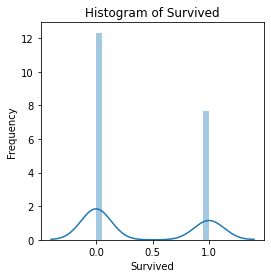

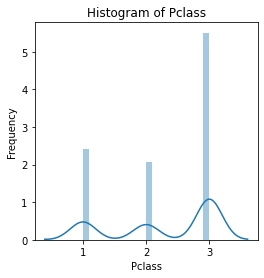

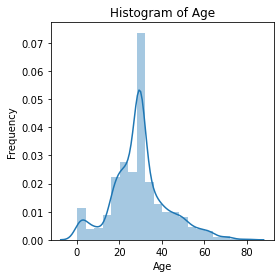

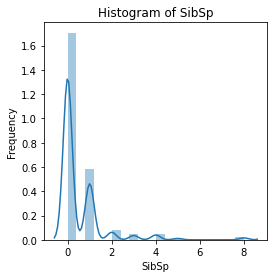

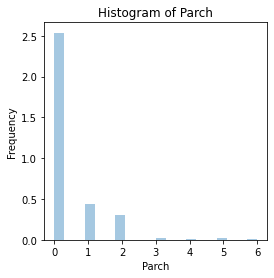

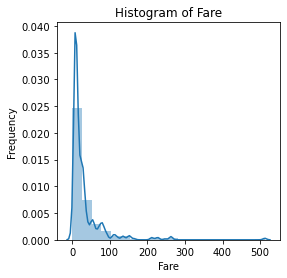

In [6]:
#Distribution Analysis of Numeric Columns:
for column in train:
    if train[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(4, 4))
        sns.distplot(train[column], bins=20)  
        #sns.boxplot(train[column])  
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

### Exploratory Data Analysis

During the Exploratory Data Analysis (EDA) phase, several key insights were gleaned from the Titanic dataset. The Correlation Analysis is most important element for this time. 

**Analysis of Numerical Columns:**
- Basic statistics such as mean, standard deviation, and maximum values were examined.
- The maximum age was observed to be 80 years, which is reasonable. The average age was approximately 29.6 years.
- The maximum number of siblings/spouses aboard (SibSp) was 8, which, while high, is plausible.
- A minimum fare of 0 was noted, likely attributable to crew members such as the captain.

**Distribution Comparison of Numerical Columns:**
- Standardization was applied for a uniform comparison.
- The age distribution closely resembled a Gaussian distribution.
- SibSp, Parch, and Fare showed left-skewed distributions, with Fare exhibiting the longest tail.

**Distribution of Categorical Columns:**
- The most common class was the 3rd grade, occupying a larger portion of the dataset.
- The ratio of males to females was approximately 2:1.

**Correlation Analysis:**
- A significant positive correlation was observed between 'Survived' and 'Fare', and a negative correlation with 'Pclass'.
- High negative correlations were noted with 'Sex_male' and 'Title_Mr', indicating higher survival rates for female passengers.
- Potential multicollinearity issues were identified, such as between 'Fare' and 'Pclass', and a perfect correlation between 'Sex_male' and 'Title_Mr'. Additionally, 'Sex_male' correlated with 'Title_Mrs'. These findings are crucial for subsequent analysis, as the impact of multicollinearity varies across different machine learning models."

In [7]:
#Analysis of Numerical Columns:
train_original.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


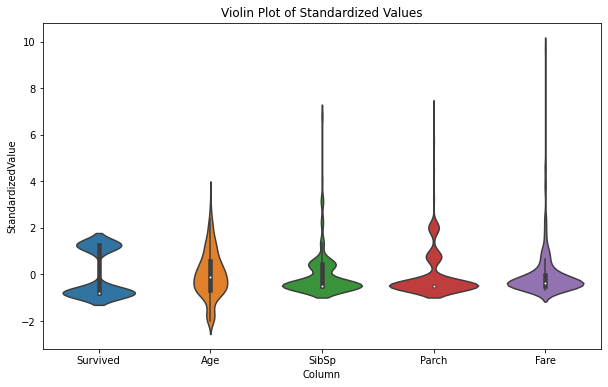

In [8]:
#Distribution Comparison of Numerical Columns
columns_to_plot = ['Survived', 'Age', 'SibSp','Parch','Fare'] 
scaler = StandardScaler()
train_standardized = pd.DataFrame(scaler.fit_transform(train_original[columns_to_plot]), columns=columns_to_plot)
train_long = pd.melt(train_standardized, value_vars=columns_to_plot, var_name='Column', value_name='StandardizedValue')


plt.figure(figsize=(10, 6))
sns.violinplot(x='Column', y='StandardizedValue', data=train_long)
plt.title('Violin Plot of Standardized Values')
plt.show()

In [9]:
#Distribution of Categorical Columns
print(train_original['Pclass'].value_counts())
print(train_original['Sex'].value_counts())
print(train_original['Embarked'].value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


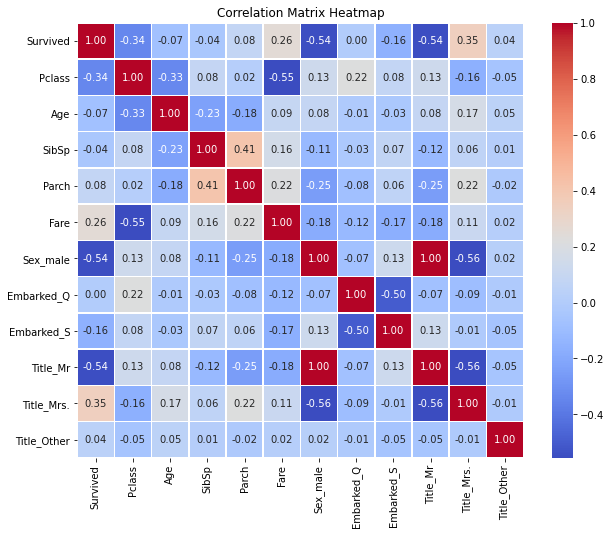

In [10]:
#Correlation Analysis
corr_matrix = train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
#train = train.drop('Sex_female', axis=1)
#train = train.drop('Sex_male', axis=1)

In [12]:
#corr_matrix = train.corr()

#plt.figure(figsize=(10, 8))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
#plt.title('Correlation Matrix Heatmap')
#plt.show()

In [13]:
#_ = pd.plotting.scatter_matrix(train, c = train['Survived'], figsize =[8,8],s = 150 ,marker = 'D')



### Modeling

In the modeling phase of the Titanic dataset analysis, the following steps were undertaken. 

**Data Splitting:**
- The training data was divided into X_train, X_test, y_train, and y_test subsets to evaluate the performance of the models. 30% of the dataset was allocated to the test set.

**Model Selection:**
- Three types of models were evaluated: Logistic Regression, Decision Tree, and Support Vector Machine (SVM), as this was a classification problem. These models were chosen for their relative ease of implementation and performance assessment.

**Hyperparameter Tuning:**
- For each model, two hyperparameters were selected for tuning. The values for these hyperparameters were chosen based on a heuristic approach.

**Use of Pipeline and GridSearchCV:**
- To streamline the comparison of different models and hyperparameter settings, Pipeline and GridSearchCV methods were employed.

**PCA and Standardization:**
- PCA was utilized to minimize the impact of potential multicollinearity observed in the data.
Standard scaling was applied to mitigate the effects of skewed distributions.

**Model Evaluation Metrics:**
- Accuracy and F1 score were the primary metrics used to determine the best model. Although the target variable 'Survived' did not exhibit a heavily skewed distribution, making accuracy a suitable metric, F1 score was also considered for a comprehensive evaluation.

**Cross-Validation:**
- To reduce the risk of overfitting, cross-validation was performed. A 5-fold cross-validation approach was used for each model.

**Feature Importance:**
- Feature importance analysis was not conducted. This decision aligns with the project's focus on prediction rather than explanatory analysis, and the use of PCA, which, while beneficial for handling multicollinearity, reduces the interpretability of individual features."

**Discussion**
While the modeling approach in this analysis was comprehensive, it's important to acknowledge that not all possible machine learning techniques were explored. This leaves room for further investigation. For example:

- Exploring Additional Models: Models like RandomForest, known for its robustness and effectiveness in classification tasks, could be a  alternative to explore.

- Expanding Hyperparameter Tuning: There are numerous hyperparameters for each model, and exploring a wider range or different combinations could potentially improve performance.

Given these considerations, it's possible that further optimization and enhancement of the model's performance are achievable. Additionally, it's worth noting that the choice of preprocessing steps, particularly the use of PCA, was aligned with the project's focus on prediction accuracy. However, if the objective were to emphasize feature importance and interpretability, omitting the PCA step would have been more appropriate. This would allow for a more direct analysis of how individual features influence the prediction, which is crucial in explanatory models.

In [44]:
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state =42)
print("# of train rows are " + str(X_train.shape[0]) + ", and # of test rows are " + str(X_test.shape[0]))

# of train rows are 623, and # of test rows are 268


In [15]:
X_train.head(1)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Mr,Title_Mrs.,Title_Other
445,1,4.0,0,2,81.8583,1,0,1,1,0,0


In [16]:
# Logistic Regression Pipeline
pipeline_lr = Pipeline([
    ('scaler1', StandardScaler()),
    ('pca1', PCA(n_components=2)),
    ('logreg', LogisticRegression(random_state= 42))
])

pipeline_dt = Pipeline([
    ('scaler2', StandardScaler()),
    ('pca2', PCA(n_components=2)),
    ('dt', DecisionTreeClassifier())
])

pipeline_svc = Pipeline([
    ('scaler3', StandardScaler()),
    ('pca3', PCA(n_components=2)),
    ('svc', SVC())
])


In [17]:
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'svc__gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001]  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

In [18]:
pipelines = [pipeline_lr,pipeline_dt,pipeline_svc]

In [19]:
best_acc= 0.0
best_f1= 0.0
best_clr_acc=0
best_clr_f1=0
best_pipeline_acc = ""
best_pipeline_f1 = ""

In [20]:
pipe_dict = {
    0: 'Logistic Regression',
    1: 'Decision Tree',
    2: 'SVM'
}
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [21]:
for i, model in enumerate(pipelines):
    print(" {} Test Accuracy: {}" .format(pipe_dict[i], model.score(X_test,y_test)))

 Logistic Regression Test Accuracy: 0.7388059701492538
 Decision Tree Test Accuracy: 0.7574626865671642
 SVM Test Accuracy: 0.7947761194029851


In [22]:
for i, model in enumerate(pipelines):
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    if model.score(X_test, y_test) > best_acc:
        best_acc = model.score(X_test,y_test)
        best_pipeline = model
        best_clr = i
    if f1 > best_f1:
        best_f1 = f1
        best_pipeline_f1 = pipe_dict[i]
        best_clr_f1 = i
print('Calssifier with best accuracy: {}' . format(pipe_dict[best_clr]))
print(f"Best Model: {best_pipeline_f1 } with a Test F1 of {best_f1}")

Calssifier with best accuracy: SVM
Best Model: SVM with a Test F1 of 0.7417840375586854


In [23]:
# Parameter grid for Logistic Regression
param_grid_lr = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l2','l1']
}

# Parameter grid for Decision Tree
param_grid_dt = {
    'dt__max_depth': [None,1, 3, 10, 20],
    'dt__min_samples_split': [2, 5, 10, 20]
}

# Parameter grid for SVC
param_grid_svc = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['rbf', 'linear']
}

# GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy')
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='accuracy')
grid_pipelines = [grid_search_lr, grid_search_dt, grid_search_svc]

In [24]:
best_acc= 0.0
best_f1= 0.0
best_clr_acc=0
best_clr_f1=0
best_pipeline_acc = ""
best_pipeline_f1 = ""

In [25]:
columns = ['Model', 'Params', 'Accuracy', 'F1']
results_df = pd.DataFrame(columns=columns)

In [26]:
best_model_acc = None
best_model_f1 = None
for i, grid_pipeline in enumerate(grid_pipelines):
    grid_pipeline.fit(X_train, y_train)
    
    best_estimator = grid_pipeline.best_estimator_
    y_pred = best_estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{pipe_dict[i]} Best Parameters: {grid_pipeline.best_params_}")
    print(f"{pipe_dict[i]} Test Accuracy: {grid_pipeline.score(X_test, y_test)}")
    print(f"{pipe_dict[i]} F1 Score: {f1}")
    
    new_row = {
    'Model': pipe_dict[i],
    'Params': grid_pipeline.best_params_,
    'Accuracy': grid_pipeline.score(X_test, y_test),
    'F1': f1
    }
    results_df = results_df.append(new_row, ignore_index=True)
    
    # Compare to find the best model
    if grid_pipeline.score(X_test, y_test) > best_acc:
        best_acc = grid_pipeline.score(X_test, y_test)
        best_pipeline_acc = pipe_dict[i]
        best_clr_acc = i
        best_model_acc = best_estimator 
    if f1 > best_f1:
        best_f1 = f1
        best_pipeline_f1 = pipe_dict[i]
        best_clr_f1 = i
        best_model_f1 = best_estimator 
print(f"Best Model: {best_pipeline_acc} with a Test Accuracy of {best_acc}")
print(f"Best Model: {best_pipeline_f1 } with a Test F1 of {best_f1}")


Logistic Regression Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2'}
Logistic Regression Test Accuracy: 0.7388059701492538
Logistic Regression F1 Score: 0.6391752577319586
Decision Tree Best Parameters: {'dt__max_depth': 1, 'dt__min_samples_split': 2}
Decision Tree Test Accuracy: 0.7873134328358209
Decision Tree F1 Score: 0.7164179104477612
SVM Best Parameters: {'svc__C': 10, 'svc__kernel': 'rbf'}
SVM Test Accuracy: 0.7873134328358209
SVM F1 Score: 0.7164179104477612
Best Model: Decision Tree with a Test Accuracy of 0.7873134328358209
Best Model: Decision Tree with a Test F1 of 0.7164179104477612


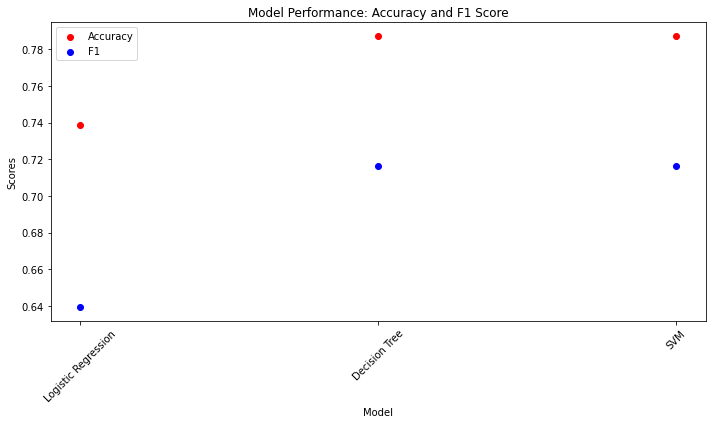

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Model'], results_df['Accuracy'], color='red', label='Accuracy')
plt.scatter(results_df['Model'], results_df['F1'], color='blue', label='F1')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Performance: Accuracy and F1 Score')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

plt.legend()
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


In [28]:
print(best_model_acc)
print(best_model_f1)

Pipeline(memory=None,
         steps=[('scaler2',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca2',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=1,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
 

In [29]:
best_model_f1.named_steps['dt'].feature_importances_

array([1., 0.])

In [30]:
results_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_dt = pd.DataFrame(grid_search_dt.cv_results_)
results_svc = pd.DataFrame(grid_search_svc.cv_results_)

relevant_columns = ['params', 'mean_test_score']
results_lr['model'] = 'Logistic Regression'
results_dt['model'] = 'Decision Tree'
results_svc['model'] = 'SVC'

all_results = pd.concat([results_lr, results_dt, results_svc])


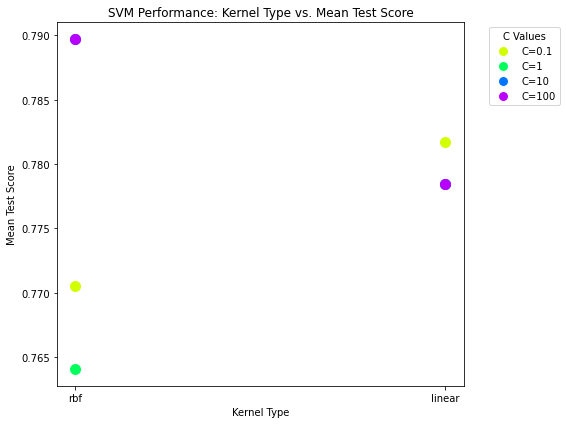

In [31]:
results = pd.DataFrame(grid_search_svc.cv_results_)
import matplotlib.pyplot as plt
import seaborn as sns

# Unique C values and their corresponding colors
unique_C = results['param_svc__C'].unique()
colors = sns.color_palette("hsv", len(unique_C))
color_map = dict(zip(unique_C, colors))

plt.figure(figsize=(8, 6))

# Plot each point
for _, row in results.iterrows():
    color = color_map[row['param_svc__C']]
    plt.scatter(row['param_svc__kernel'], row['mean_test_score'], color=color, label=f"C={row['param_svc__C']}",s = 100)

# Title and labels
plt.title('SVM Performance: Kernel Type vs. Mean Test Score')
plt.xlabel('Kernel Type')
plt.ylabel('Mean Test Score')

# Create a legend
# To avoid duplicate labels in the legend, we create custom legend entries
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'C={c}', 
                          markerfacecolor=color, markersize=10)
                   for c, color in color_map.items()]
plt.legend(handles=legend_elements, title="C Values", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



In [32]:
pd.DataFrame(grid_search_dt.cv_results_).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004284,0.000204,0.001076,0.000045,None,2,"{'dt__max_depth': None, 'dt__min_samples_split...",0.744,0.728,0.68,0.733871,0.766129,0.7304,0.028353,18


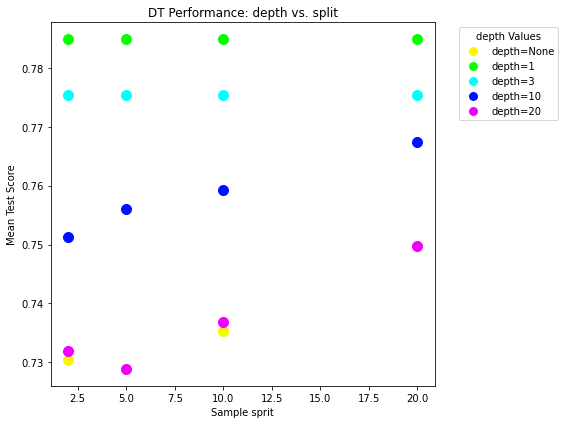

In [33]:
results = pd.DataFrame(grid_search_dt.cv_results_)

# Unique C values and their corresponding colors
unique_C = results['param_dt__max_depth'].unique()
colors = sns.color_palette("hsv", len(unique_C))
color_map = dict(zip(unique_C, colors))

plt.figure(figsize=(8, 6))

# Plot each point
for _, row in results.iterrows():
    color = color_map[row['param_dt__max_depth']]
    plt.scatter(row['param_dt__min_samples_split'], row['mean_test_score'], color=color, label=f"depth={row['param_dt__max_depth']}",s = 100)

# Title and labels
plt.title('DT Performance: depth vs. split')
plt.xlabel('Sample sprit')
plt.ylabel('Mean Test Score')

# Create a legend
# To avoid duplicate labels in the legend, we create custom legend entries
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'depth={c}', 
                          markerfacecolor=color, markersize=10)
                   for c, color in color_map.items()]
plt.legend(handles=legend_elements, title="depth Values", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



### Results and Analysis

The analysis revealed that the Decision Tree Classifier emerged as the best model based on the evaluation metrics used. Specifically, it achieved an accuracy of 0.787 and an F1 score of 0.716. This clear performance edge makes the Decision Tree Classifier the preferred choice for this particular problem. However, it's important to note the following observations:

**SVM Performance:**
The Support Vector Machine (SVM) model displayed a performance comparable to the Decision Tree, particularly with the RBF kernel and C parameter set to 100. This suggests that SVM could also be a viable model in practical applications.

**Logistic Regression Performance:**
In contrast, the Logistic Regression model did not clear competitive performance in terms of either accuracy or F1 score. This aligns with the observation that linear models (including Linear SVM) did not perform as well, which is consistent with the nature of the data and the problem.

**Decision Tree Parameters:**
For the Decision Tree model, a depth of 1 was consistently the best across all sample splits, with minimal variation in performance due to changes in split criteria. This could be attributed to the application of PCA during preprocessing, which may have reduced the importance of split depth and criteria in the model's performance.

In summary, while the Decision Tree Classifier stands out based on the metrics, the close performance of the SVM model, especially with specific parameter settings, suggests it should not be discounted for potential real-world application. The results also indicate that simpler models, such as Logistic Regression, might not be sufficient for this dataset, possibly due to its complexity and the nature of the variables involved

### Discussion and Conclusion


In this project, the Titanic dataset was analyzed with the primary goal of accurately predicting the 'Survived' flag, using passenger attributes such as age and fare. The dataset was relatively clean, but required some data cleaning, including imputation for missing data. Given the classification nature of the problem and the availability of a target variable, supervised machine learning techniques were employed, specifically Logistic Regression, Decision Tree, and SVM.

Following preprocessing steps like PCA and hyperparameter tuning, the Decision Tree Classifier emerged as the best model, achieving an accuracy of 0.78 and an F1 score of 0.71.

**Learnings and Takeaways:**

- The limited effectiveness of linear regression models suggests that the dataset likely has a non-linear distribution. Both SVM and Decision Tree performed well, with SVM showing potential to surpass Decision Tree, although not all hyperparameters were explored.
- The success of the Decision Tree, often considered a more basic ML technique compared to SVM or RandomForest, underscores that complexity does not always equate to higher performance. This was particularly evident after standardization and PCA preprocessing.

**Challenges Encountered (Things did not work well) :**

- Hyperparameter tuning for the Decision Tree was less impactful, possibly due to the use of PCA. The optimal tree depth was consistently found to be 1, indicating that removing PCA or using alternative methods might yield different results.
- The hyperparameter search, while guided by GridSearchCV, was limited by the heuristic selection of parameters, leading to only marginal improvements.

**Suggestions for Improvement:**

- Incorporation of additional categorical variables, such as Cabin numbers or Passenger ID, which were not used in this analysis, could reveal hidden patterns and potentially enhance accuracy.
- Exploring alternative methods for missing value imputation, particularly for age. While the mean was a reasonable choice given the Gaussian-like distribution, other approaches like using the mode might offer better results.

In [ ]:
## for submitting data to Kaggle. 

In [34]:
test = pd.read_csv('data/test.csv')
test['Title'] = test['Name'].apply(lambda name: extract_title(name, title_mapping))
                                                                
#Handling Missing Values (NA)
mean_age_test = test['Age'].mean()
test['Age'] = test['Age'].fillna(mean_age_test)
mean_age_test = test['Fare'].mean()
test['Fare'] = test['Fare'].fillna(mean_age_test)
test.isna().sum()

#Creation of Dummy Variables
test = pd.get_dummies(test, columns=['Sex'], drop_first=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Title'], drop_first=True)
# Dropping Columns
test = test.drop(['Name','Ticket', 'Cabin'], axis=1)
test["Title_Other"] = 0

In [35]:
test.isna().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Sex_male       0
Embarked_Q     0
Embarked_S     0
Title_Mr       0
Title_Mrs.     0
Title_Other    0
dtype: int64

In [36]:
print(X_test.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 709 to 430
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       268 non-null    int64  
 1   Age          268 non-null    float64
 2   SibSp        268 non-null    int64  
 3   Parch        268 non-null    int64  
 4   Fare         268 non-null    float64
 5   Sex_male     268 non-null    uint8  
 6   Embarked_Q   268 non-null    uint8  
 7   Embarked_S   268 non-null    uint8  
 8   Title_Mr     268 non-null    uint8  
 9   Title_Mrs.   268 non-null    uint8  
 10  Title_Other  268 non-null    uint8  
dtypes: float64(2), int64(3), uint8(6)
memory usage: 14.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age

In [37]:
print(len(test))
print(len(test.drop('PassengerId', axis=1)))
print(len(best_pipeline.predict(test.drop('PassengerId', axis=1))))

418
418
418


In [42]:
test_a = pd.DataFrame(test["PassengerId"].copy())
print(len(test_a))
print(test_a.head(1))
result = pd.DataFrame(best_pipeline.predict(test.drop('PassengerId', axis=1)))
test_a['Survival'] =result
print(len(result))
#print(best_pipeline.predict(test.drop('PassengerId', axis=1)))
print(test_a.head(1))

418
   PassengerId
0          892
418
   PassengerId  Survival
0          892         0


In [39]:
test_a.head(10)

,PassengerId
0,892
1,893
2,894
3,895
4,896
5,897
6,898
7,899
8,900
9,901


In [43]:
test_a.to_csv('data/result_a.csv', index=False)
#result.to_csv('data/result_b.csv', index=False)